In [1]:
import os
import math
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
path = "/Users/jorgerag/Documents/UCSD/courses/Winter23/COGS181/final_project/"
os.chdir(path)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
def get_source(df):
    res = []
    for i in range(0, len(df)):
        res.append(np.array(df["gcamp_lp"].iloc[i], dtype="float32"))
    res = np.array(res)
    return torch.from_numpy(res[1:])

In [3]:
class PositionalEncoding(
    nn.Module,
):
    # needs to go at the bottom of the encoder and decoder stacks
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 3000):
        super().__init__()

        # Hyperparameter: to introduce regularization that prevents against overfitting
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        pe = torch.squeeze(pe)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :].requires_grad_(False)
        return self.dropout(x)

In [4]:
class Transformer(nn.Module):

    # input var
    def __init__(
        self,
        num_input_variables,
        dim_val,
        encoder_dim_feedforward_d_model_scalar,
        encoder_dropout,
        encoder_num_layers,
        encoder_activation,
        encoder_num_heads,
        decoder_dim_feedforward_d_model_scalar,
        decoder_dropout,
        decoder_num_layers,
        decoder_num_heads,
        decoder_activation,
        max_seq,
        num_classes, 
        embedding_size
    ):
        
        super().__init__()
        self.encoder_input_layer = nn.Linear(in_features=max_seq, out_features=dim_val)
        self.positional_encoding = PositionalEncoding(dim_val, max_len=max_seq)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=encoder_num_heads,
            dim_feedforward=dim_val * encoder_dim_feedforward_d_model_scalar,
            dropout=encoder_dropout,
            activation=encoder_activation)
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=encoder_num_layers)
        self.batchnorm = nn.LazyBatchNorm1d()
        self.decoder_input_layer = nn.Linear(in_features=num_input_variables, out_features=dim_val)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=decoder_num_heads,
            dim_feedforward=dim_val * decoder_dim_feedforward_d_model_scalar,
            dropout=decoder_dropout,
            activation=decoder_activation)
        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=decoder_num_layers)
        self.linear = nn.Linear(in_features=dim_val, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=num_classes)

    def forward(self, source, target):
        source = self.encoder_input_layer(source)
        source = self.positional_encoding(source)
        source = self.encoder(source)
        target = self.batchnorm(target)
        target_up = self.decoder_input_layer(target)
        target_up = self.decoder(target_up, source)
        target_up = self.linear(target_up)
        target_up = F.relu(target_up)
        target_up = self.out(target_up)
        target_up = F.relu(target_up)
        return target + target_up

In [5]:
trainingset = pd.DataFrame(pd.read_json("data/processed/train_data.json"))
testset = pd.DataFrame(pd.read_json("data/processed/test_data.json"))
# drop infs
trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]

# Get valdiation split
unique_obj = trainingset.groupby(["subject", "threshold", "day"]).size().reset_index()
unique_obj = unique_obj.to_dict('records')
unique_obj_df = pd.DataFrame(unique_obj)[['subject', 'day']]
# Split to train and validation
## Take one trial per subject as validation choosing randonmly from each of the subjects with more than one day.
validation_trials = unique_obj_df[~unique_obj_df["subject"].isin([3203, 3315])].groupby('subject').apply(lambda x: x.sample(n = 1, random_state = 123)).reset_index(drop=True)
keys = list(validation_trials.columns.values)
i1 = trainingset.set_index(keys).index
i2 = validation_trials.set_index(keys).index

train_df = trainingset[~i1.isin(i2)]
validation_df = trainingset[i1.isin(i2)]

## Divide datasets by trials
gb = train_df.groupby(["subject", "day"])
trials = [gb.get_group(x) for x in gb.groups]

gb_val = validation_df.groupby(["subject", "day"])
val_trials = [gb_val.get_group(x) for x in gb_val.groups]

gb_test = testset.groupby(["subject", "day"])
test_trials = [gb_test.get_group(x) for x in gb_test.groups]

/var/folders/mj/fbzmtcxx50g7hksjvdvr0kh00000gn/T/ipykernel_83906/3167382495.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
/var/folders/mj/fbzmtcxx50g7hksjvdvr0kh00000gn/T/ipykernel_83906/3167382495.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]


In [32]:
train_df

,index,order,subject,threshold,day,lp_duration,lp_met,gcamp_lp
273,0,1,3201,1600,5,98.7584,0,"[0.9945129353000001, -0.9988724316, 0.99759425..."
274,1,2,3201,1600,5,401.8880,0,"[-0.9792381630000001, 1.0204380394, -1.0248441..."
275,2,3,3201,1600,5,1593.7984,0,"[-0.9783720489000001, 1.0142978659, -1.0009839..."
276,3,4,3201,1600,5,119.2640,0,"[0.4850764115, -0.9627900625, 0.4839136821, -0..."
277,4,5,3201,1600,5,201.2480,0,"[-0.4784104514, -0.2655072241, -0.4814230459, ..."
...,...,...,...,...,...,...,...,...
9631,187,188,4269,1600,8,1847.8144,1,"[-0.998850639, 1.0065643227, -0.981000399, 1.0..."
9632,188,189,4269,1600,8,1769.6576,1,"[-0.9932717333000001, 1.0046274211, -0.9908246..."
9633,189,190,4269,1600,8,1368.4160,0,"[1.0154129302, -1.0005916681, 1.0151740317, -0..."
9634,190,191,4269,1600,8,475.6416,0,"[-0.9513113023, 1.3370446279000001, -0.9647325..."


In [33]:
validation_df

,index,order,subject,threshold,day,lp_duration,lp_met,gcamp_lp
0,0,1,3201,1600,2,668.1536,0,"[0.9945129353000001, -0.9988724316, 0.99759425..."
1,1,2,3201,1600,2,668.1536,0,"[-0.9802292554, 1.1326303507, -0.9752135088, 1..."
2,2,3,3201,1600,2,749.6000,0,"[1.0172488034, -0.9977053451000001, 1.00518157..."
3,3,4,3201,1600,2,1450.0288,0,"[-0.9966975375, 0.9976137768000001, -0.9975107..."
4,4,5,3201,1600,2,771.0784,0,"[-0.9934138135, 1.1337681919, -0.9962171890000..."
...,...,...,...,...,...,...,...,...
8606,187,188,4269,1600,5,2376.0448,1,"[-1.0015867914, 1.0036396322, -1.0042990003, 0..."
8607,188,189,4269,1600,5,872.9024,0,"[-0.9959880674, 1.0073760173, -0.9948411839, 1..."
8608,189,190,4269,1600,5,2281.9520,1,"[0.9872610133, -0.9992418081000001, 0.99554239..."
8609,190,191,4269,1600,5,1749.3824,1,"[-1.0013452009, 1.0093181139, -1.0030402773, 0..."


In [34]:
testset

,index,order,subject,threshold,day,lp_duration,lp_met,gcamp_lp
147,0,1,3201,1600,4,569.7728,0,"[0.9945129353000001, -0.9988724316, 0.99759425..."
148,1,2,3201,1600,4,139.7568,0,"[0.9989046823000001, -1.0051915679, 1.01090163..."
149,2,3,3201,1600,4,619.0144,0,"[-0.9511541525, 0.43798035550000003, -0.957171..."
150,3,4,3201,1600,4,188.8832,0,"[-0.9937581649, 0.9959443319000001, -1.0228102..."
151,4,5,3201,1600,4,672.2752,0,"[-1.0082032383, 1.0081887119, -1.0135296024, 1..."
...,...,...,...,...,...,...,...,...
8414,284,285,4269,1600,3,418.2592,0,"[-0.9841470965, 0.3490437274, -0.9664244401000..."
8415,285,286,4269,1600,3,7782.6240,1,"[1.019678853, -0.9860788484, 1.0043391428, -1...."
8416,286,287,4269,1600,3,1978.9376,1,"[-0.9786856304, 0.8569155161, -0.9586608907, 0..."
8417,287,288,4269,1600,3,5988.5632,1,"[0.9771894441000001, -1.0200516667, 0.99820152..."


In [6]:
dim_val = 20
n_heads = 10
n_decoder_layers = 4
n_encoder_layers = 4
max_seq = 703
embedding_size = 10
num_classes = 1

epochs = 25
lr = 0.001
momentum = 0.9
loss_function = nn.MSELoss()

model = Transformer(
    num_input_variables=1,
    dim_val=dim_val,
    encoder_dim_feedforward_d_model_scalar=5,
    encoder_dropout=0.4,
    encoder_num_layers=n_encoder_layers,
    encoder_activation="relu",
    encoder_num_heads=n_heads,
    decoder_dim_feedforward_d_model_scalar=5,
    decoder_dropout=0.4,
    decoder_num_layers=n_decoder_layers,
    decoder_num_heads=n_heads,
    decoder_activation="relu",
    max_seq=max_seq,
    num_classes=num_classes,
    embedding_size=embedding_size
)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

all_losses = []
for epoch in range(epochs):
    train_loss = 0
    model.train()
    for trial in trials:
        optimizer.zero_grad()
        source = get_source(trial)
        # Padding source to max lenght of sequence
        source = F.pad(source, pad=(0, 0, 0, max_seq + 1 - len(trial)), mode="constant", value=0).T
        target = torch.tensor(trial["lp_duration"][1:].values).to(torch.int64)
        target = target.unsqueeze(1).type(torch.FloatTensor)
        predicted_lp = model(source=source, target=target)
        loss = loss_function(predicted_lp, target)
        loss.backward()
        optimizer.step()
        train_loss += (loss.item()/len(target))
    all_losses.append(train_loss / len(trials))
    print("---------------------------------------------")
    print("Epoch: ", epoch)
    print("Average Training RMSE:", math.sqrt(train_loss / len(trials)))
    # Print validation accuracy
    model.eval()
    validation_loss = 0
    for val in val_trials:
        source_val = get_source(val)
        source_val = F.pad(source_val, pad=(0, 0, 0, max_seq + 1 - len(val)), mode="constant", value=0).T
        target_val = torch.tensor(val["lp_duration"][1:].values).to(torch.int64)
        target_val = target_val.unsqueeze(1).type(torch.FloatTensor)
        with torch.no_grad():
            predicted_val = model(source=source_val, target=target_val)
            loss_val = loss_function(predicted_val, target_val)
            validation_loss += (loss_val.item()/len(target_val))
    print("Average Validation RMSE:", math.sqrt(validation_loss / len(val_trials)))
            

/Users/jorgerag/.pyenv/versions/3.9.16/envs/cogs181/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


---------------------------------------------
Epoch:  0
Average Training RMSE: 590.2424268415498
Average Validation RMSE: 165.25026704630213
---------------------------------------------
Epoch:  1
Average Training RMSE: 192.83010493930095
Average Validation RMSE: 118.83504824207796
---------------------------------------------
Epoch:  2
Average Training RMSE: 159.59463566596497
Average Validation RMSE: 77.11682656285568
---------------------------------------------
Epoch:  3
Average Training RMSE: 138.3324446601436
Average Validation RMSE: 48.8729910940794
---------------------------------------------
Epoch:  4
Average Training RMSE: 127.2823844959543
Average Validation RMSE: 31.388952276372997
---------------------------------------------
Epoch:  5
Average Training RMSE: 121.85302981975805
Average Validation RMSE: 21.030548705192366
---------------------------------------------
Epoch:  6
Average Training RMSE: 119.15594879564402
Average Validation RMSE: 15.134253583366169
------------

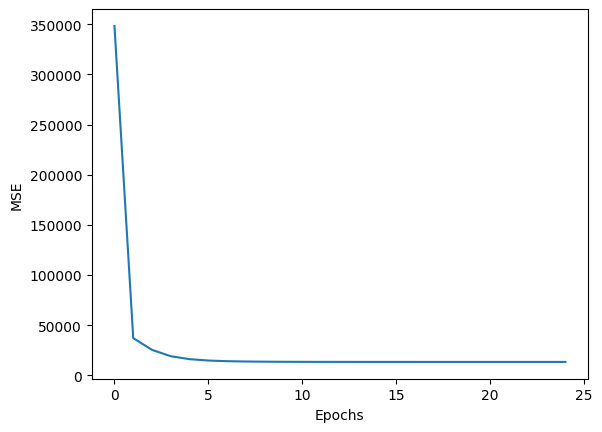

In [7]:
# Training Curve
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.plot([loss for loss in all_losses])
plt.show()

In [8]:
# Test accuracy
model.eval()
test_loss = 0
for test in test_trials:
    source_test = get_source(test)
    source_test = F.pad(source_test, pad=(0, 0, 0, max_seq + 1 - len(test)), mode="constant", value=0).T
    target_test = torch.tensor(test["lp_duration"][1:].values).to(torch.int64)
    target_test = target_test.unsqueeze(1).type(torch.FloatTensor)
    with torch.no_grad():
        predicted_test = model(source=source_test, target=target_test)
        loss_test = loss_function(predicted_test, target_test)
        test_loss += (loss_test.item()/len(target_test))
print("Average Test RMSE:", math.sqrt(test_loss / len(test_trials)))

Average Test RMSE: 12.890134900839044


In [20]:
# Plot predicted vs actual for a test case
def test_plot(i):
    source_test = F.pad(get_source(test_trials[i]), pad=(0, 0, 0, max_seq + 1 - len(test_trials[i])), mode="constant", value=0).T
    target_test = torch.tensor(test_trials[i]["lp_duration"][1:].values).unsqueeze(1).type(torch.FloatTensor)
    with torch.no_grad():
        predicted_test = model(source=source_test, target=target_test)
    df_test_plot = pd.DataFrame(list(zip([tensor.item() for tensor in target_test], [tensor.item() for tensor in predicted_test])), columns =['Target', 'Predicted'])
    fig = plt.subplots(figsize=(10, 5))
    sns.lineplot(data = df_test_plot);

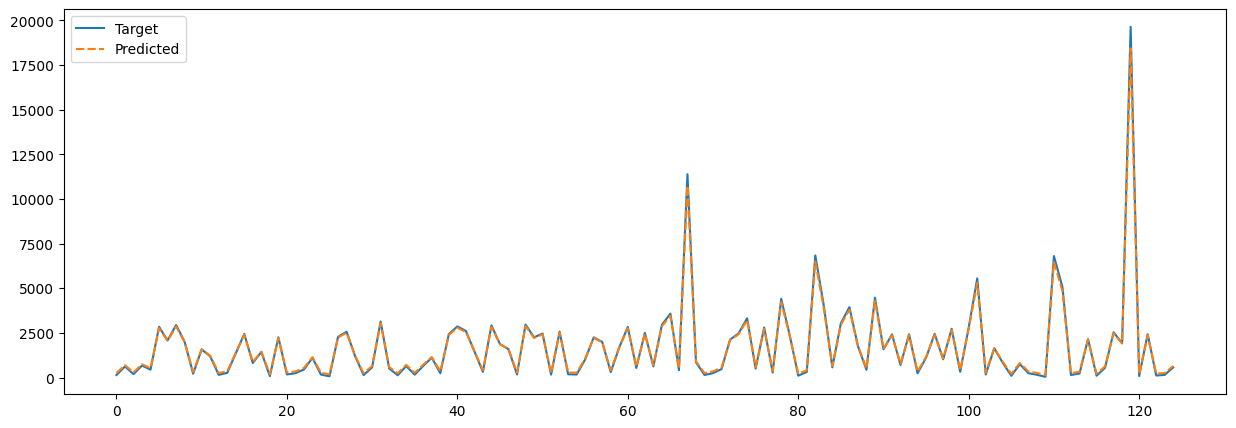

In [19]:
test_plot(0)

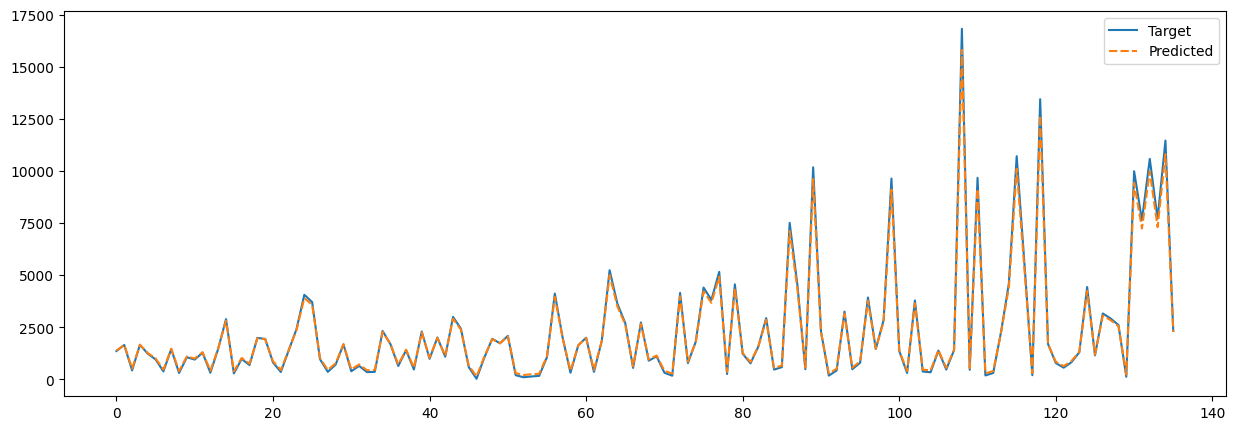

In [21]:
test_plot(1)

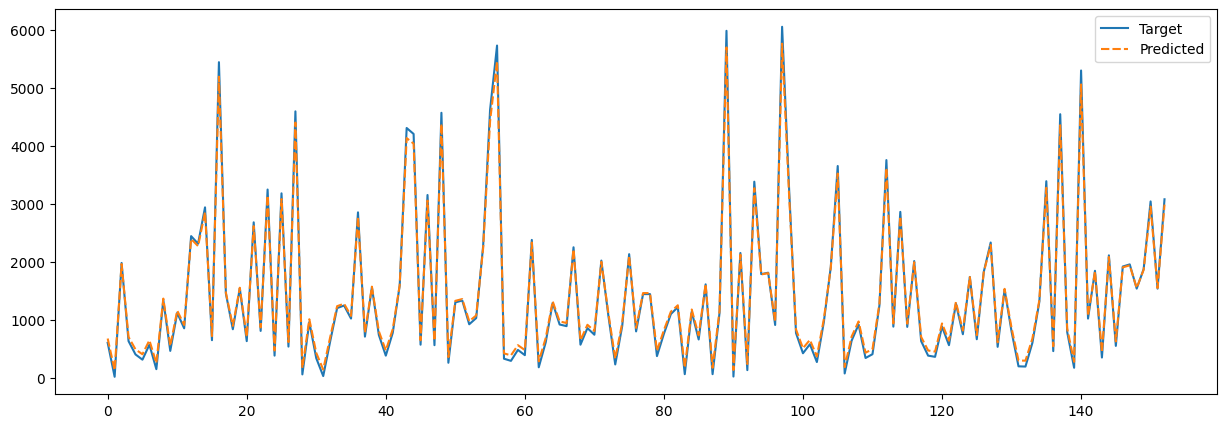

In [22]:
test_plot(2)

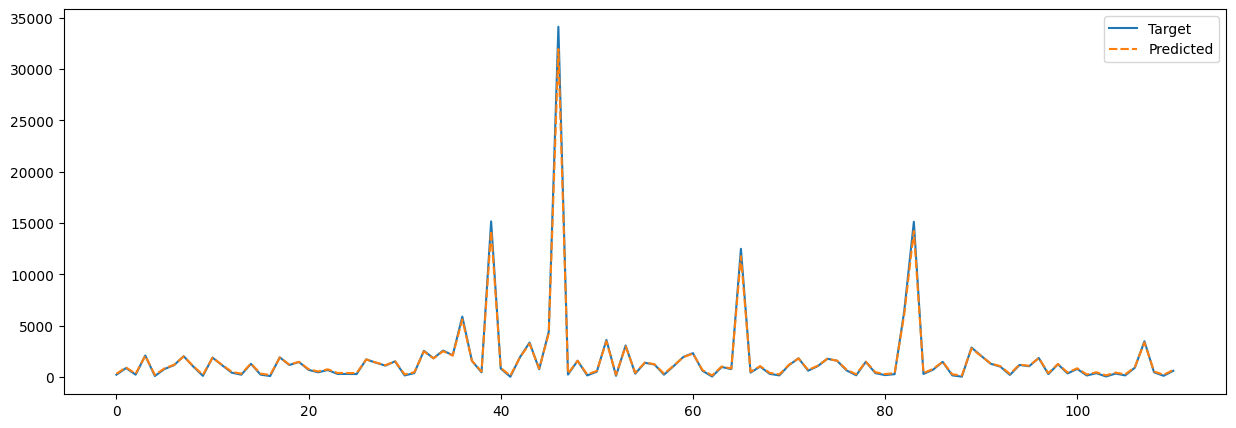

In [23]:
test_plot(3)

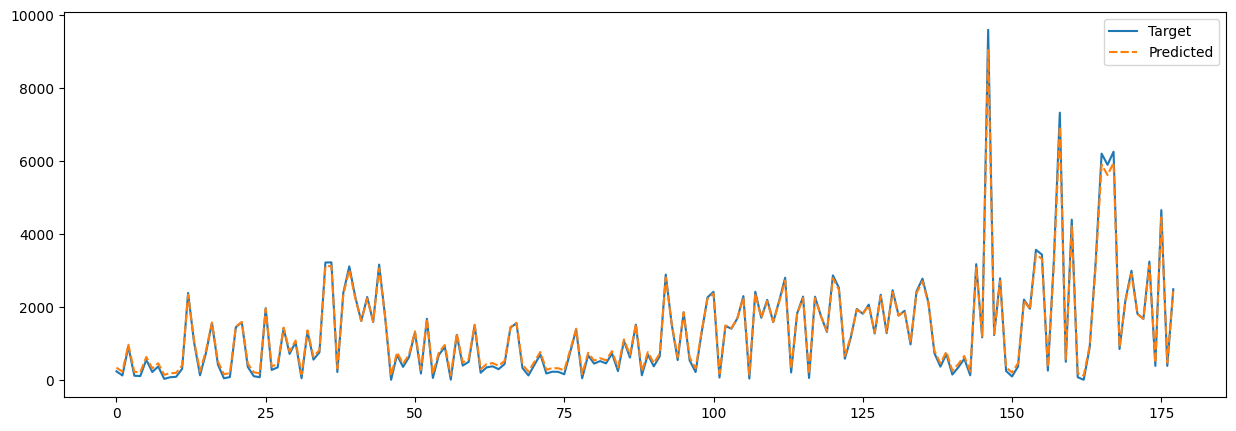

In [24]:
test_plot(4)

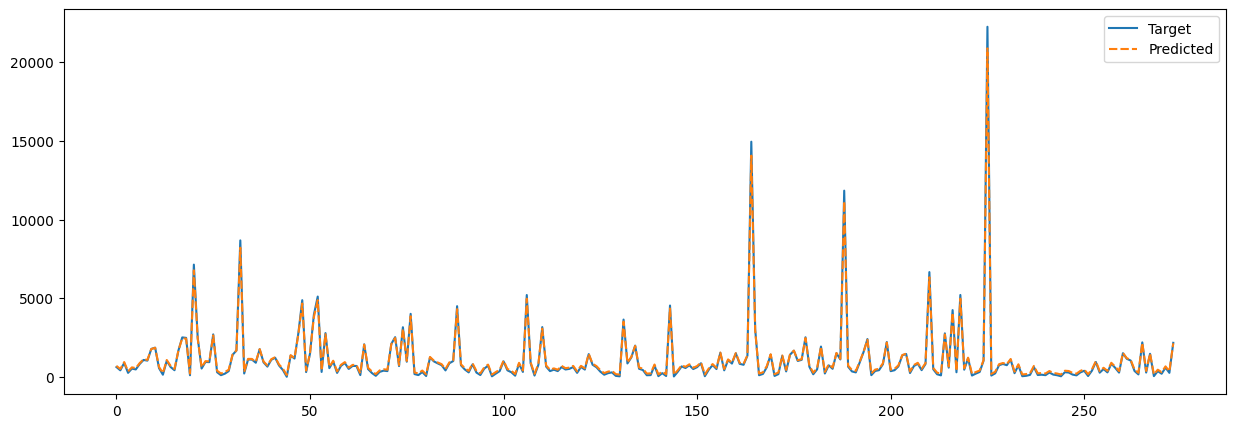

In [25]:
test_plot(5)

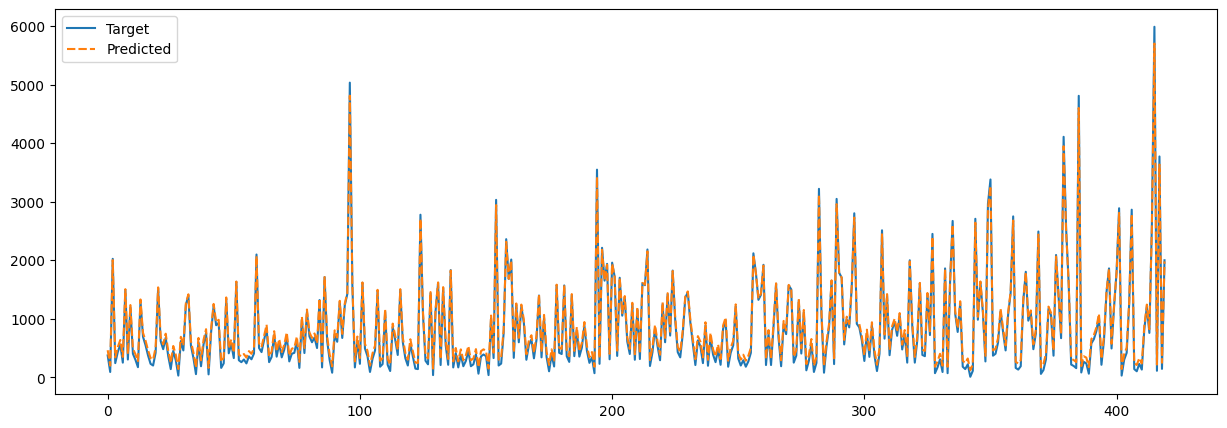

In [26]:
test_plot(6)

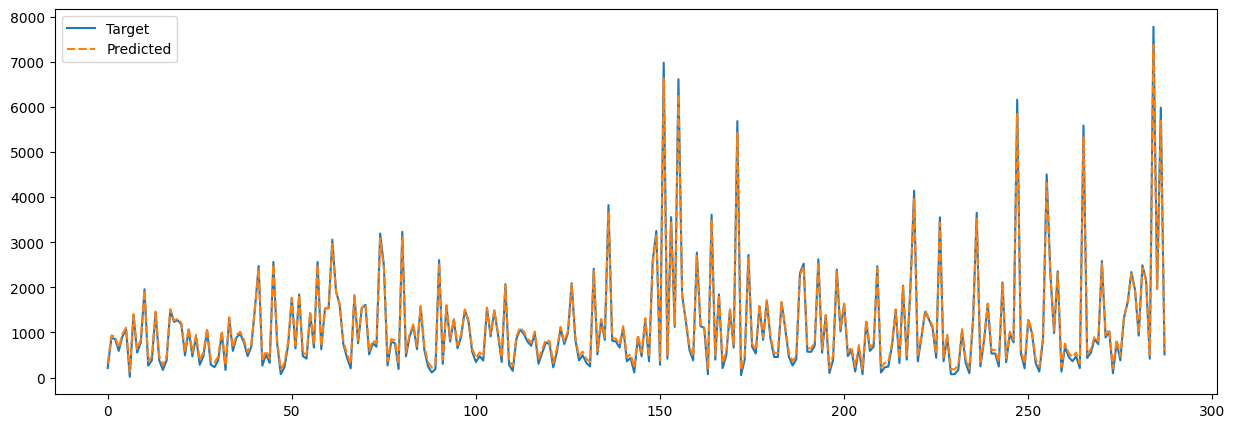

In [27]:
test_plot(7)